In [1]:
import os
os.chdir('../../')

In [2]:
%load_ext rpy2.ipython

In [3]:
from google.oauth2 import service_account
from google.cloud import bigquery

In [4]:
import numpy as np
import pandas as pd
import re

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.precision = 5

In [7]:
SERVICE_ACCOUNT = 'private/bigquery-write-access.json'
DATASET = 'student_counts'
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT)

In [8]:
bqclient = bigquery.Client(project=credentials.project_id, credentials=credentials)

# Read Data

## Student destinations

In [9]:
country_codes = {
    "Australia": 'AUS', 
    'Canada': 'CAN', 
    'United Kingdom': 'UK',
    'United States of America': 'US',
    'New Zealand': 'NZ',
    'China': 'CN', 
    'India': 'IND',
    'Malaysia': 'MYS',
    'Indonesia': 'IDN',
}
destination_col = 'dst'

In [10]:
query_string = \
"""
SELECT 
    year,
    source_country as src,
    destination_country as dst,
    dst_distance,
    dst_students_count
FROM `int-stud-mobility-drivers.datasets_for_modelling.student_destinations` 
where year < 2017
"""
destinations_df = bqclient.query(query_string).result().to_dataframe()
destinations_df[destination_col] = destinations_df[destination_col].apply(lambda x: country_codes[x])
destinations_df['src'] = destinations_df['src'].apply(lambda x: country_codes[x])

In [11]:
#destinations_df.sort_values('year')

## Destination predictors

In [12]:
query_string = \
"""
SELECT 
    year,
    dst_average_wage as av_wage,
    dst_rate_of_one_usd as rate_1usd,
    dst_cpi,
    --dst_qoe_top20,
    dst_qoe_top100,
    --dst_qoe_top200,
    --dst_qoe_top500,
    country
FROM `int-stud-mobility-drivers.datasets_for_modelling.destination_predictors` 
"""
dst_predictors_df = bqclient.query(query_string).result().to_dataframe()

In [13]:
dst_predictors_df[destination_col] = dst_predictors_df.country.apply(lambda x: country_codes[x])
del dst_predictors_df['country']
dst_predictors_df = dst_predictors_df.set_index(['year', destination_col]).unstack(destination_col)
dst_predictors_df.columns = ['{}.{}'.format(var, code) for var, code in dst_predictors_df.columns.values]

In [14]:
dst_predictors_df.head()

,av_wage.AUS,av_wage.CAN,av_wage.NZ,av_wage.UK,av_wage.US,rate_1usd.AUS,rate_1usd.CAN,rate_1usd.NZ,rate_1usd.UK,rate_1usd.US,dst_cpi.AUS,dst_cpi.CAN,dst_cpi.NZ,dst_cpi.UK,dst_cpi.US,dst_qoe_top100.AUS,dst_qoe_top100.CAN,dst_qoe_top100.NZ,dst_qoe_top100.UK,dst_qoe_top100.US
year,,,,,,,,,,,,,,,,,,,,
1996,43.974,35.989,30.546,41.233,52.147,1.27786,1.36352,1.45485,0.64096,1.0,69.40687,76.35232,73.31269,76.04032,71.93123,0,4,0,12,58
1997,44.504,36.639,31.095,41.428,52.647,1.34738,1.38460,1.51242,0.61084,1.0,69.56296,77.59015,74.18302,77.71407,73.61276,0,4,0,12,58
1998,45.034,37.289,31.643,41.623,53.148,1.59183,1.48351,1.86825,0.60382,1.0,70.16129,78.36291,75.12162,79.12891,74.75543,0,4,0,12,57
1999,45.564,37.939,32.192,41.818,53.649,1.54995,1.48570,1.88961,0.61806,1.0,71.20187,79.72238,75.03578,80.51600,76.39110,0,4,0,13,57
2000,45.459,39.380,31.806,38.908,53.904,1.72483,1.48539,2.20115,0.66093,1.0,74.37565,81.89038,76.99814,81.46847,78.97072,0,4,0,13,56


## Source predictors

In [15]:
query_string = \
"""
SELECT 
    year,
    country,
    src_population,
    --src_qoe_top20,
    --src_qoe_top100,
    --src_qoe_top200,
    src_qoe_top500,
    src_gni,
    src_gdp,
    src_rate_of_one_usd as src_rate1_usd,
    src_tertiary_enrolment as src_ter_enr
FROM `int-stud-mobility-drivers.datasets_for_modelling.source_predictors` 
"""
src_df = bqclient.query(query_string).result().to_dataframe()
src_df['country'] = src_df['country'].apply(lambda x: country_codes[x])
src_df.set_index(['year', 'country'], inplace=True)
src_df.tail()

src_population  src_qoe_top500  src_gni  src_gdp  src_rate1_usd  \
year country                                                                    
2017 MYS            31.10503             2.0   9810.0    315.0        4.30044   
2018 CN           1392.73000            62.0   9470.0  13600.0        6.61596   
     IND          1352.61733             1.0   2020.0   2730.0       68.38947   
     IDN           267.66343             0.0   3840.0   1040.0    14236.93877   
     MYS            31.52858             2.0  10460.0    354.0        4.03513   

              src_ter_enr  
year country               
2017 MYS         41.92992  
2018 CN               NaN  
     IND              NaN  
     IDN              NaN  
     MYS              NaN

# Modelling

## Discrete Choice Modelling

### Build dataset for predictions

#### Grouped data

In [139]:
mask = destinations_df.src == 'MYS1'

dcm_df = destinations_df[~mask].join(src_df, on=['year', 'src'])
dcm_df = dcm_df.join(dst_predictors_df, on='year')

def bucket_years(year):
    if year <= 2001: return '1998-01'
    if year <= 2006: return '2002-06'
    if year <= 2011: return '2007-11'
    if year <= 2016: return '2012-16'

    return 'Unknown'
    
dcm_df['yr'] = dcm_df.year.apply(bucket_years)

dcm_df.head(5)

,year,src,dst,dst_distance,dst_students_count,src_population,src_qoe_top500,src_gni,src_gdp,src_rate1_usd,src_ter_enr,av_wage.AUS,av_wage.CAN,av_wage.NZ,av_wage.UK,av_wage.US,rate_1usd.AUS,rate_1usd.CAN,rate_1usd.NZ,rate_1usd.UK,rate_1usd.US,dst_cpi.AUS,dst_cpi.CAN,dst_cpi.NZ,dst_cpi.UK,dst_cpi.US,dst_qoe_top100.AUS,dst_qoe_top100.CAN,dst_qoe_top100.NZ,dst_qoe_top100.UK,dst_qoe_top100.US,yr
0,1998,CN,AUS,7470,4132,1241.935,0.0,800.0,1030.0,8.2790,5.9510,45.034,37.289,31.643,41.623,53.148,1.5918,1.4835,1.8682,0.6038,1.0,70.1613,78.3629,75.1216,79.1289,74.7554,0,4,0,12,57,1998-01
1,1999,CN,AUS,7470,4578,1252.735,0.0,860.0,1090.0,8.2782,6.4570,45.564,37.939,32.192,41.818,53.649,1.5499,1.4857,1.8896,0.6181,1.0,71.2019,79.7224,75.0358,80.5160,76.3911,0,4,0,13,57,1998-01
2,2000,CN,AUS,7470,5008,1262.645,4.0,940.0,1210.0,8.2785,7.6209,45.459,39.380,31.806,38.908,53.904,1.7248,1.4854,2.2011,0.6609,1.0,74.3757,81.8904,76.9981,81.4685,78.9707,0,4,0,13,56,1998-01
3,2002,CN,AUS,7470,17343,1280.400,8.0,1110.0,1470.0,8.2770,12.5069,46.270,38.800,33.005,41.517,54.788,1.8406,1.5703,2.1622,0.6672,1.0,79.9688,85.8543,81.1354,83.9745,82.4905,1,4,0,13,56,2002-06
4,2003,CN,AUS,7470,23448,1288.400,12.0,1280.0,1660.0,8.2770,15.2415,46.811,38.802,34.211,42.652,55.460,1.5419,1.4010,1.7221,0.6125,1.0,82.1540,88.2227,82.5582,85.1304,84.3631,1,4,0,14,55,2002-06


In [140]:
dcm_df.to_csv('data/dcm_dataset.csv', index=False)

#### Ungrouped data

In [141]:
all_indices = []
for idx, st_count in dcm_df.dst_students_count.iteritems():
    replicates = int(st_count/100)
    #print(idx, st_count, replicates)
    a = np.full(replicates, idx)
    all_indices.append(a)

In [142]:
dcm_df.loc[np.hstack(all_indices)].to_csv("data/dcm_dataset.ungrouped.csv", index=False)

In [143]:
#list(zip(range(1, len(dcm_df.columns)+1), dcm_df.iloc[np.hstack(all_indices)]))

#### Analyze coefficients

In [184]:
fit_df = pd.read_csv("data/coefficients.txt", header=-1, names=['covariate', 'coef', 'std_error', 'zvalue', 'pvalue'])

In [185]:
mask = fit_df.pvalue > 0.06
fit_df.loc[mask, 'coef'] = 0
#fit_df[~mask]

In [186]:
mask = fit_df.covariate.str.contains(':')
df1 = fit_df[~mask].set_index('covariate')[['coef']].apply(np.exp)
for dst in ('CAN', 'NZ', 'UK', 'US'):
    df1[dst] = df1.coef
del df1['coef']
df1

,CAN,NZ,UK,US
covariate,,,,
av_wage,0.97343,0.97343,0.97343,0.97343
rate_1usd,1.41432,1.41432,1.41432,1.41432
dst_cpi,0.94847,0.94847,0.94847,0.94847
dst_qoe_top100,0.98540,0.98540,0.98540,0.98540


In [187]:
dcm_fit_df = fit_df[mask][['coef']].copy()
dcm_fit_df['dst'] = fit_df.covariate.apply(lambda x: x.split(':')[0])
dcm_fit_df['covariate'] = fit_df.covariate.apply(lambda x: x.split(':', 1)[-1])

In [188]:
dcm_fit_df = dcm_fit_df.set_index(['covariate', 'dst']).unstack('dst')
dcm_fit_df.columns = dcm_fit_df.columns.droplevel(0)

#dcm_fit_df.reset_index(inplace=True)
#dcm_fit_df

In [190]:
df2 = dcm_fit_df.apply(np.exp).applymap(lambda x: '{:.5f}'.format(x))
df = pd.concat([df1, df2.iloc[1:]])

In [191]:
df

dst,CAN,NZ,UK,US
covariate,,,,
av_wage,0.97343,0.97343,0.97343,0.97343
rate_1usd,1.4143,1.4143,1.4143,1.4143
dst_cpi,0.94847,0.94847,0.94847,0.94847
dst_qoe_top100,0.9854,0.9854,0.9854,0.9854
srcIDN,0.00005,1.00000,0.00001,0.00000
srcIND,0.05130,0.12382,0.09385,0.05523
srcMYS,0.00001,1.00000,0.00001,0.00000
src_gdp,0.99983,0.99969,1.00000,1.00008
src_gni,1.00000,1.00000,1.00000,0.99985


In [221]:
predictors = ['dst_av_wage',
'dst_rate_1usd',
'dst_cpi',
'dst_qoe_top100',
'src_gdp',
'src_gni',
'src_population',
'src_qoe_top500',
'src_ter_enr',
'yr2002\-06',
'yr2007\-11',
'yr2012\-16',
'yr2002\-06_srcIDN',
'yr2002\-06_srcIND',
'yr2002\-06_srcMYS',
'yr2007\-11_srcIDN',
'yr2007\-11_srcIND',
'yr2007\-11_srcMYS',
'yr2012-16_srcIDN',
'yr2012-16_srcIND',
'yr2012-16_srcMYS']

In [230]:
values  = [' + \\beta_{} {{{}}} '.format(idx, item.replace('_','.')) for idx, item in enumerate(predictors)]

print(' '.join(values))

 + \beta_0 {dst.av.wage}   + \beta_1 {dst.rate.1usd}   + \beta_2 {dst.cpi}   + \beta_3 {dst.qoe.top100}   + \beta_4 {src.gdp}   + \beta_5 {src.gni}   + \beta_6 {src.population}   + \beta_7 {src.qoe.top500}   + \beta_8 {src.ter.enr}   + \beta_9 {yr2002\-06}   + \beta_10 {yr2007\-11}   + \beta_11 {yr2012\-16}   + \beta_12 {yr2002\-06.srcIDN}   + \beta_13 {yr2002\-06.srcIND}   + \beta_14 {yr2002\-06.srcMYS}   + \beta_15 {yr2007\-11.srcIDN}   + \beta_16 {yr2007\-11.srcIND}   + \beta_17 {yr2007\-11.srcMYS}   + \beta_18 {yr2012-16.srcIDN}   + \beta_19 {yr2012-16.srcIND}   + \beta_20 {yr2012-16.srcMYS} 


$
\begin{equation} \label{eq1}
\begin{split}
A & = \frac{\pi r^2}{2} \\
 & = \frac{1}{2} \pi r^2
\end{split}
\end{equation}
$

$
\log \frac{P(going\phantom cchosen\phantom ccountry)}{P(going\phantom tto\phantom rreference\phantom ccountry)} = \beta_0 {dst.av.wage}  \\
+ \beta_1 {dst.rate.1usd}   \\
+ \beta_2 {dst.cpi} \\
+ \beta_3 {dst.qoe.top100} \\
+ \beta_4 {src.gdp} \\
+ \beta_5 {src.gni} \\
+ \beta_6 {src.population} \\
+ \beta_7 {src.qoe.top500} \\
+ \beta_8 {src.ter.enr}
$

$
\frac{P(going\phantom cchosen\phantom ccountry)}{P(going\phantom tto\phantom rreference\phantom ccountry)} = e^{\beta_0{dst.av.wage}}
e^{\beta_1 {dst.rate.1usd}} 
e^{\beta_2 {dst.cpi}}
e^{\beta_3 {dst.qoe.top100}}\\
e^{\beta_4 {src.gdp}} 
e^{\beta_5 {src.gni}} 
e^{\beta_6 {src.population}}
e^{\beta_7 {src.qoe.top500}}
e^{\beta_8 {src.ter.enr}}
$

## Multinomial (src_country predictors)

In [34]:
src_df.head()

src_population  src_qoe_top500  src_gni  src_gdp  src_rate1_usd  \
year country                                                                    
1960 CN            667.07000             NaN      NaN      NaN            NaN   
     IND           450.54768             NaN      NaN      NaN            NaN   
     IDN            87.75107             NaN      NaN      NaN            NaN   
     MYS             8.15635             NaN      NaN      NaN            NaN   
1961 CN            660.33000             NaN      NaN      NaN            NaN   

              src_ter_enr  
year country               
1960 CN               NaN  
     IND              NaN  
     IDN              NaN  
     MYS              NaN  
1961 CN               NaN

In [47]:
#destinations_df.pivot(index=['year', 'src', 'dst'], values=['dst_students_count'])
multinom_df = destinations_df.pivot_table(index=['year', 'src'], 
                                          columns=['dst'], 
                                          values='dst_students_count').reset_index()
multinom_df[multinom_df.year <= 2016]
multinom_df.head()

dst,year,src,AUS,CAN,NZ,UK,US
0,1998,CN,4132,2820,78,2877,43000
1,1998,IDN,7721,384,272,1090,11800
2,1998,IND,3613,696,47,3112,31000
3,1998,MYS,16118,807,1892,17197,11000
4,1999,CN,4578,3489,247,4250,46949


In [48]:
multinom_df = multinom_df.join(src_df, on=['year', 'src'])
multinom_df.head()

,year,src,AUS,CAN,NZ,UK,US,src_population,src_qoe_top500,src_gni,src_gdp,src_rate1_usd,src_ter_enr
0,1998,CN,4132,2820,78,2877,43000,1241.93500,0.0,800.0,1030.00000,8.27896,5.95095
1,1998,IDN,7721,384,272,1090,11800,205.72459,0.0,660.0,95.44555,10013.62250,13.35983
2,1998,IND,3613,696,47,3112,31000,1019.48358,3.0,410.0,421.00000,41.25937,6.22946
3,1998,MYS,16118,807,1892,17197,11000,22.11465,0.0,3640.0,72.16775,3.92437,21.65023
4,1999,CN,4578,3489,247,4250,46949,1252.73500,0.0,860.0,1090.00000,8.27825,6.45695


In [49]:
response_cols = [item for item in destinations_df.dst.unique()]
predictor_cols = [item for item in src_df.columns]
#predictor_cols = [item for item in dataset_df.columns if item.startswith('src')]

In [50]:
response_df = multinom_df[response_cols].astype(int)
predictors_df = multinom_df[predictor_cols]

In [51]:
%%R -i response_df -i predictors_df
library(nnet)
p_ = as.matrix(predictors_df)
model = multinom(as.matrix(response_df) ~ p_)

# weights:  40 (28 variable)
initial  value 14090633.751674 
iter  10 value 11705477.681935
iter  20 value 11640858.324414
iter  30 value 11073088.745980
iter  40 value 10840942.458297
final  value 10840941.249734 
converged


In [52]:
%%R
coefs = round((t(coef(model))), 4)
#names = dimnames(coefs)
coefs

                     CAN      UK      NZ      US
(Intercept)      -5.2261 -0.8127 -4.7816  0.0081
p_src_population  0.0033  0.0006  0.0023  0.0012
p_src_qoe_top500 -0.0130 -0.0028  0.0312 -0.0469
p_src_gni         0.0002  0.0000  0.0000 -0.0001
p_src_gdp        -0.0001 -0.0001 -0.0005  0.0002
p_src_rate1_usd   0.0001 -0.0001  0.0000  0.0000
p_src_ter_enr     0.0149  0.0072  0.0752 -0.0100


In [53]:
%R -o coefs

In [54]:
coefs

array([[-5.2261e+00, -8.1270e-01, -4.7816e+00,  8.1000e-03],
       [ 3.3000e-03,  6.0000e-04,  2.3000e-03,  1.2000e-03],
       [-1.3000e-02, -2.8000e-03,  3.1200e-02, -4.6900e-02],
       [ 2.0000e-04,  0.0000e+00, -0.0000e+00, -1.0000e-04],
       [-1.0000e-04, -1.0000e-04, -5.0000e-04,  2.0000e-04],
       [ 1.0000e-04, -1.0000e-04, -0.0000e+00, -0.0000e+00],
       [ 1.4900e-02,  7.2000e-03,  7.5200e-02, -1.0000e-02]])

In [60]:
%%R
head(round(fitted(model), 3)*100)

   AUS CAN   UK  NZ   US
0 13.4 4.6 13.1 1.9 67.0
1 47.8 1.7  6.2 1.1 43.1
2 19.5 3.1 16.8 2.5 58.0
3 43.3 0.7 26.2 1.7 28.1
4 13.2 4.7 13.0 2.0 67.1
5 45.8 1.4  8.2 1.3 43.3


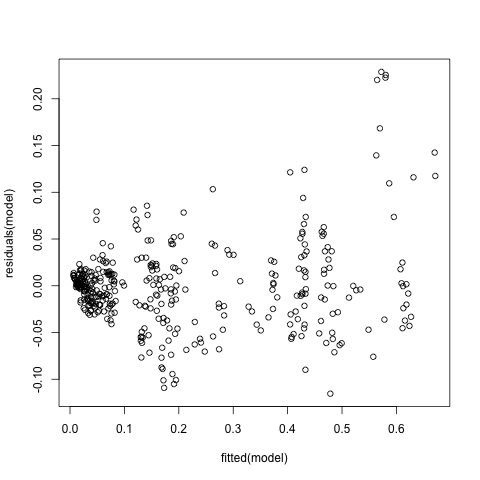

In [56]:
%%R
plot(fitted(model), residuals(model))

In [59]:
%%R
head(round(residuals(model), 3)*100)

    AUS  CAN   UK   NZ   US
0  -5.6  0.8 -7.7 -1.8 14.2
1 -11.5  0.1 -1.1  0.1 12.4
2 -10.1 -1.3 -8.7 -2.4 22.5
3  -9.0  1.1 10.3  2.3 -4.7
4  -5.5  1.2 -5.9 -1.6 11.7
5  -5.1  0.3 -2.9  0.3  7.4
